In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import pandas as pd
import glob

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(directory = 'Group_8/train/',image_size=(224, 224))
val_dataset = tf.keras.utils.image_dataset_from_directory(directory = 'Group_8/val/',image_size=(224, 224))
test_dataset = tf.keras.utils.image_dataset_from_directory(directory = 'Group_8/test/',image_size=(224, 224))

Found 150 files belonging to 3 classes.
Found 30 files belonging to 3 classes.
Found 60 files belonging to 3 classes.


In [6]:
X_train = np.concatenate([x for x, y in train_dataset], axis=0)
Y_train = np.concatenate([y for x, y in train_dataset], axis=0)

X_val = np.concatenate([x for x, y in val_dataset], axis=0)
Y_val = np.concatenate([y for x, y in val_dataset], axis=0)

X_test = np.concatenate([x for x, y in test_dataset], axis=0)
Y_test = np.concatenate([y for x, y in test_dataset], axis=0)

In [7]:
print(X_train.shape)

(150, 224, 224, 3)


In [8]:
print(Y_train.shape)

(150,)


## Ques -1 : Obtaining Feature Map of Image 

In [9]:
img = X_train[15]

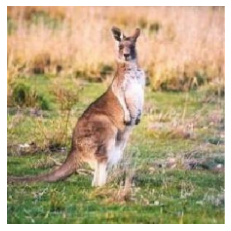

In [10]:
plt.imshow((img).astype(np.uint8))
plt.axis('off')
plt.show()

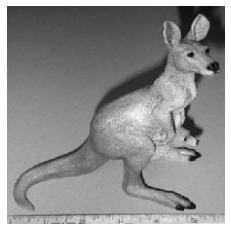

In [10]:
img_bw = np.dot(img[...,:3], [0.299, 0.587, 0.114]).reshape(img.shape[0],img.shape[1],1)
plt.imshow((img_bw).astype(np.uint8), cmap='gray')
plt.axis('off')
plt.show()

In [11]:
#kaiming TBD
def kaiming_initialization(f, nC_prev,  nC): 
    return np.random.randn(f, f, nC_prev, nC)*np.sqrt(1./nC_prev)

def zero_pad(X, pad): 
    X_pad = np.pad(X, ((0,0), (pad, pad), (pad, pad), (0,0)), mode = 'constant', constant_values = (0,0))
    return X_pad

def conv_static(a_slice_prev, W, b):
    static_conv_out = np.sum(a_slice_prev * W)+float(b)
    return static_conv_out

def conv_forward(A_prev, W, b, stride, pad): 
    (m, nH_prev, nW_prev, nC_prev) = A_prev.shape
    (f, f, nC_prev, nC) = W.shape
    nH = int((nH_prev+(2*pad)-f)/stride)+1
    nW = int((nW_prev+(2*pad)-f)/stride)+1
    
    Z = np.zeros((m,nH, nW, nC))
    A = np.zeros((m, nH, nW, nC))
    A_prev_pad = zero_pad(A_prev, pad)
    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        for h in range(nH):
            vert_start = h
            vert_end = (h*stride)+f
            for w in range(nW): 
                horiz_start = w
                horiz_end = (w*stride)+f
                for c in range(nC):
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, : ]
                    weights = W[:, :, :, c]
                    biases = b[:, :, :, c]
                    Z[i,h,w,c] = conv_static(a_slice_prev, weights, biases)
                    A[i,h,w,c] = 0 if Z[i, h, w, c]<=0 else Z[i,h,w,c]
                            
    return Z, A

In [12]:
img_bw = img_bw.reshape(1, img_bw.shape[0], img_bw.shape[1], img_bw.shape[2])
W = kaiming_initialization(3, img_bw.shape[3], 1)
b = np.zeros((1, 1, 1, 1))
Z, A = conv_forward(img_bw, W, b, 1, 0)

In [13]:
Z.shape

(1, 222, 222, 1)

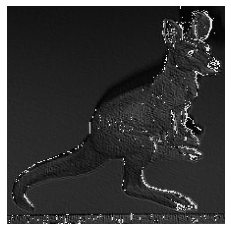

In [14]:
feature_map = Z.reshape(Z.shape[1], Z.shape[2], 1)
plt.imshow((feature_map).astype(np.uint8), cmap='gray')
plt.axis('off')
plt.show()

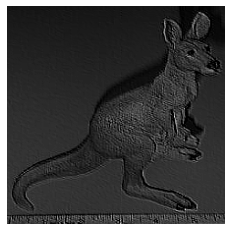

In [15]:
feature_map = A.reshape(A.shape[1], A.shape[2], 1)
plt.imshow((feature_map).astype(np.uint8), cmap='gray')
plt.axis('off')
plt.show()

## Ques-2 

In [16]:
def relu(x):
    return x * (x > 0)

def d_relu(x):
    return 1 * (x > 0)

def init_param(self, size): 
    stddev = 1/np.sqrt(np.prod(size))
    return np.random.normal(loc=0, scale=stddev, size=size)

In [19]:
class Conv2D:
    def __init__(self, filters =1, kernel_size =3, stride = 1, padding = 0, activation = 'relu', kernel_initializer = 'kaiming_initialization'):
        kernel_initializer_map = {
            "kaiming_initialization" : kaiming_initialization
        }
        
        activation_fn_map = {
            "relu": (relu, d_relu)
        }
        self.W, self.B = None, None
        self.Z, self.cache, self.A = None, None, None
        
        self.filters = filters
        self.kernel_size = kernel_size
        self.stride = stride 
        self.padding = padding 
        self.activation = activation_fn_map[activation]
        self.kernel_initializer = kernel_initializer_map[kernel_initializer]   
    
    def __call__(self, A_prev): 
        self.W = self.kernel_initializer(self.kernel_size, A_prev.shape[3], self.filters)
        self.B = np.random.randn(1, 1, 1, self.filters)
        self.Z, self.A = conv_forward(A_prev, self.W, self.B, self.stride, self.padding)
        return self.A

In [20]:
conv_layer1 = Conv2D(32)
A1 = conv_layer1(img_bw)


In [21]:
A1.shape

(1, 222, 222, 32)

In [22]:
conv_layer2 = Conv2D(64)
A2 = conv_layer2(A1)

In [23]:
A2.shape

(1, 220, 220, 64)

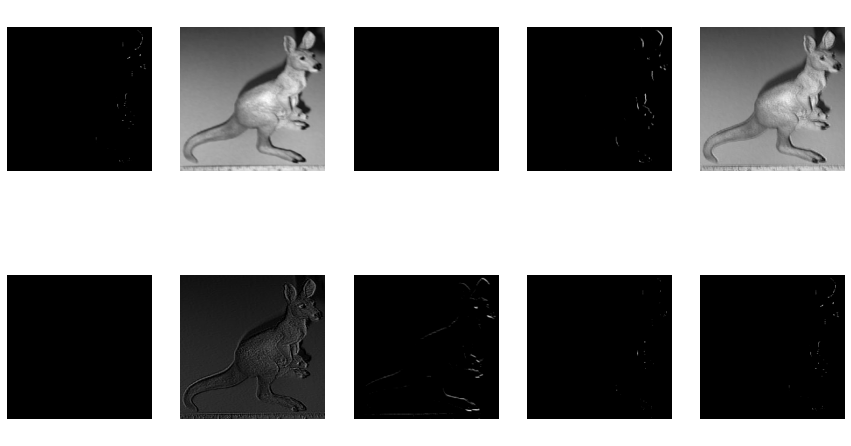

In [24]:
cols = 5
rows = 2
fig, axes = plt.subplots(rows,cols,figsize=(15,15))
[axi.set_axis_off() for axi in axes.ravel()]
for i in range(1,11):
    filter_index = np.random.randint(0,32)
    fig.add_subplot(rows, cols, i)
    plt.imshow(A1[:,:, :, filter_index].reshape(A1.shape[1], A1.shape[2], 1), cmap='gray')
    plt.axis('off')
    
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.5, 
                    wspace=0.2, 
                    hspace=0.35)
plt.show()

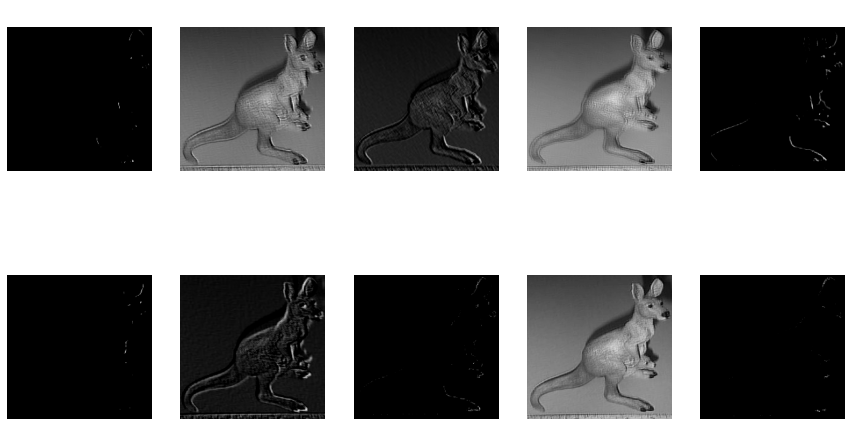

In [25]:
cols = 5
rows = 2
fig, axes = plt.subplots(rows,cols,figsize=(15,15))
[axi.set_axis_off() for axi in axes.ravel()]
for i in range(1,11):
    filter_index = np.random.randint(0,64)
    fig.add_subplot(rows, cols, i)
    plt.imshow(A2[:,:, :, filter_index].reshape(A2.shape[1], A2.shape[2], 1), cmap='gray')
    plt.axis('off')
    
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.5, 
                    wspace=0.2, 
                    hspace=0.35)
plt.show()

## Ques-3

In [61]:
class Conv2D:
    def __init__(self, filters =1, kernel_size =3, stride = 1, padding = 0, activation = 'relu', kernel_initializer = 'kaiming_initialization'):
        kernel_initializer_map = {
            "kaiming_initialization" : kaiming_initialization
        }
        
        activation_fn_map = {
            "relu": (relu, d_relu)
        }
        self.A_prev = None
        self.W, self.B = None, None
        self.Z, self.A = None, None
        self.dZ, self.dA_prev, self.dW, self.dB = None, None, None, None
        
        self.filters = filters
        self.kernel_size = kernel_size
        self.stride = stride 
        self.padding = padding 
        self.activation = activation_fn_map[activation]
        self.kernel_initializer = kernel_initializer_map[kernel_initializer]
    
    def convv_forward(self, A_prev, W, B, stride, pad): 
        (m, nH_prev, nW_prev, nC_prev) = A_prev.shape
        (f, f, nC_prev, nC) = W.shape
        nH = int((nH_prev+(2*pad)-f)/stride)+1
        nW = int((nW_prev+(2*pad)-f)/stride)+1
    
        Z = np.zeros((m,nH, nW, nC))
        A = np.zeros((m, nH, nW, nC))
        A_prev_pad = zero_pad(A_prev, pad)
        for i in range(m):
            a_prev_pad = A_prev_pad[i]
            for h in range(nH):
                vert_start = h
                vert_end = (h*stride)+f
                for w in range(nW): 
                    horiz_start = w
                    horiz_end = (w*stride)+f
                    for c in range(nC):
                        a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, : ]
                        weights = W[:, :, :, c]
                        biases = B[:, :, :, c]
                        Z[i,h,w,c] = conv_static(a_slice_prev, weights, biases)
                        A[i,h,w,c] = 0 if Z[i, h, w, c]<=0 else Z[i,h,w,c]
                                    
        self.Z = Z
        self.A = A
        return self.A  
    
    def convv_backward(self, dZ, stride, pad):
        (m,nH_prev, nW_prev , nC_prev) = self.A_prev.shape
        (f,f,nC_prev, nC) = self.W.shape
        (m, nH, nW, nC) = dZ.shape
        
        dA_prev = np.zeros((m,nH,nW,nC))
        dW = np.zeros((f,f,nC_prev, nC))
        dB = np.zeros(self.B.shape)
        
        A_prev_pad = zero_pad(self.A_prev, pad)
        dA_prev_pad = zero_pad(dA_prev, pad)
        
        for i in range(m):                       
            a_prev_pad = A_prev_pad[i]
            da_prev_pad = dA_prev_pad[i]
            
            for h in range(nH):                  
               for w in range(nW):               
                   for c in range(nC):           
                        
                        vert_start = h*stride
                        vert_end = (h*stride)+f
                        horiz_start = w*stride
                        horiz_end = (w*stride)+f
    
                        a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
    
                        da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += self.W[:,:,:,c]*dZ[i,h,w,c]
                        self.dW[:,:,:,c] += a_slice*dZ[i,h,w,c]
                        self.dB[:,:,:,c] += dZ[i,h,w,c]
                        
        dA_prev[i, :, :, :] = da_prev_pad[i,:,:,:]
    
    
        self.dA_prev = dA_prev
        self.dW = dW
        self.dB = dB
    
        assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
        return dA_prev, dW, db
    
    def __call__(self, A_prev):
        self.A_prev = A_prev
        self.W = self.kernel_initializer(self.kernel_size, A_prev.shape[3], self.filters)
        self.B = np.random.randn(1, 1, 1, self.filters)
        return self.convv_forward(A_prev, self.W, self.B, self.stride, self.padding)

In [62]:
conv1 = Conv2D(3)
A_conv1 = conv1(img_bw)

In [63]:
A_conv1.shape

(1, 222, 222, 3)

In [64]:
conv2 = Conv2D(6)
A_conv2 = conv2(A_conv1)

In [65]:
A_conv2.shape

(1, 220, 220, 6)

In [67]:
dA2_prev, dW2_prev, dB2_prev = conv2.convv_backward(A_conv2, conv2.stride, conv2.padding)

ValueError: operands could not be broadcast together with shapes (3,3,6) (3,3,3) (3,3,6) 

In [ ]:
class Sequential():
    def __init__(self, *layers, loss=None):
        self.prev_layer_size = None
        self.layers = []
        self.L = 0
        self.loss = loss
        if layers:
            for layer in layers:
                self.add(layer)
            
    def __call__(self, X):
        return self.forward_propagation(X)
                
    def add(self, layer):
        if isinstance(layer, Input):
            self.layers.append(layer)
            self.prev_layer_size = layer.n_inputs
        elif isinstance(layer, Dense):
            self.layers.append(layer)
            if not self.prev_layer_size:
                raise Exception("Input size not provided")
            layer.W = np.random.normal(scale=1/np.sqrt(self.prev_layer_size), size=(layer.units, self.prev_layer_size))
            layer.B = np.zeros((layer.units,))
            self.L += 1
            self.prev_layer_size = layer.units
        elif isinstance(layer, Conv2D):
            self.layers.append(layer)
            if not self.prev_layer_size:
                raise Exception("Input size not provided")
            self.L += 1
            layer.filters = 
        else:
            raise TypeError("Invalid layer")
            
    def forward_propagation(self, X):
        for layer in self.layers:
            X = layer(X)
        return X
    
    def back_propagation(self, Y, batch_size):
        self.layers[-1].grad_L_A = self.loss.grad(Y, self.layers[-1].H, self.layers[-1].A)
        for i in range(len(self.layers) - 1, 0, -1):
            if isinstance(self.layers[i], Conv2D):
                
            if not isinstance(self.layers[i], Input):
                self.layers[i].grad_L_W = (1 / batch_size) * (self.layers[i].grad_L_A @ self.layers[i-1].H.T)
                self.layers[i].grad_L_B = (1 / batch_size) * np.sum(self.layers[i].grad_L_A, axis=1)
            if not isinstance(self.layers[i-1], Input):
                self.layers[i-1].grad_L_H = self.layers[i].W.T @ self.layers[i].grad_L_A
                self.layers[i-1].grad_L_A = self.layers[i-1].grad_L_H * self.layers[i-1].d_activation(self.layers[i-1].A)
            # parameter update
            self.layers[i].W = self.layers[i].W - self.lr * self.layers[i].grad_L_W
            self.layers[i].B = self.layers[i].B - self.lr * self.layers[i].grad_L_B
    
    def fit(self, train_data, label, batch_size=32, lr=1, epochs=5):
        self.lr = lr
        self.batch_size = batch_size
        # make batches
        total_data = train_data.shape[1]
        nbatches = int(np.ceil(total_data/self.batch_size))
        self.losses = []
        for e in range(epochs):
            err = 0
            print(f"Epoch {e+1}\n-------------------------------")
            for i in range(nbatches):
                begin = i * self.batch_size
                end = min(begin + self.batch_size, total_data)
                X = train_data[:, begin:end]
                Y = label[:, begin:end]
                Y_pred = self.forward_propagation(X)
                self.back_propagation(Y, end-begin)
                err += self.loss(Y, Y_pred)
            self.losses.append(err/nbatches)
        print("Done!")
                    
class Input:
    def __init__(self, n_inputs):
        self.n_inputs = n_inputs
        self.H = None
        
    def __call__(self, X, **kwargs):
        self.H = X
        return self.H

class Dense:
    # TODO: make activation_fn_map and other activation functions static
    def __init__(self, units, activation):
        activation_fn_map = {
            "sigmoid": (sigmoid, d_sigmoid),
            "relu": (relu, d_relu),
            "linear": (identity, d_identity),
            "softmax": (softmax, None),
        }
        # TODO: add functionality for input_shape
        self.units = units
        self.H, self.A = None, None
        self.W, self.B = None, None
        self.grad_L_H, self.grad_L_A = None, None
        self.grad_L_W, self.grad_L_B = None, None
        self.activation, self.d_activation = activation_fn_map[activation]
    
    def __call__(self, X):
        self.A = self.W @ X + self.B.reshape(-1, 1)
#         self.A = np.clip(self.A, -709, 709)
        self.H = self.activation(self.A)
        return self.H

class Conv2D:
    def __init__(self, filters, kernel_size, strides, padding, activation, kernel_initializer):
        kernel_initializer_map = {
            "kaiming_initialization" : {kaiming_initialization}
        }
        activation_fn_map = {
            "relu": (relu, d_relu)
        }
        self.W, self.B = None, None
        self.Z, self.A = None, None, None
        
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides 
        self.padding = padding 
        self.activation = activation_fn_map[activation]
        self.kernel_initialzer = kernel_initializer_map[kernel_initializer]
        
    def __call__(self, A_prev):
        self.W = self.kernel_initializer(self.kernel_size, A_prev.shape[3], self.filters)
        self.B = np.zeros((1, 1, 1, self.filters))
        self.Z, self.A, = conv_forward(A_prev, self.W, self.B, self.strides, self.padding)
        return self.A 
        
class CrossEntropyLoss:
    def __init__(self, activation):
        self.activation = activation
    
    def __call__(self, y_true, y_pred):
        t = np.argmax(y_true, axis=0)
        return -np.log(y_pred[t, np.arange(t.shape[0])]).mean()
        
    def grad(self, y_true, y_pred, *args, **kwargs):
        if self.activation == 'softmax':
            return y_pred - y_true
        else:
            raise Exception('Not implemented')
    
class MeanSquaredLoss:
    def __init__(self, activation):
        self.activation = activation
    
    def __call__(self, y_true, y_pred):
        return np.mean((y_pred - y_true) ** 2)
        
    def grad(self, y_true, y_pred, A):
        if self.activation == 'sigmoid':
            return (y_pred - y_true) * d_sigmoid(A)
        elif self.activation == 'linear':
            return y_pred - y_true
        elif self.activation == 'relu':
            return (y_pred - y_true) * d_relu(A)
        else:
            raise Exception('Not implemented')